In [2]:
!pip install -Uq pydicom pylibjpeg[all] python-gdcm monai

# Slice level

In [1]:
!wget https://github.com/ShahinSHH/COVID-CT-MD/raw/main/Sample%20data/COVID-19%20subjects/P002/IM0004.dcm -O test.dcm

--2024-07-13 15:58:04--  https://github.com/ShahinSHH/COVID-CT-MD/raw/main/Sample%20data/COVID-19%20subjects/P002/IM0004.dcm
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShahinSHH/COVID-CT-MD/main/Sample%20data/COVID-19%20subjects/P002/IM0004.dcm [following]
--2024-07-13 15:58:04--  https://raw.githubusercontent.com/ShahinSHH/COVID-CT-MD/main/Sample%20data/COVID-19%20subjects/P002/IM0004.dcm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230878 (225K) [application/octet-stream]
Saving to: 'test.dcm'

test.dcm            100%[===================>] 225.47K  --.-KB/s    in 0.1s    

2024-07-1

In [163]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

In [164]:
def normalize(img, maxval, reshape=False):
    """Scales images to be roughly [-1024 1024]."""

    if img.max() > maxval:
        raise Exception("max image value ({}) higher than expected bound ({}).".format(img.max(), maxval))

    img = (2 * (img.astype(np.float32) / maxval) - 1.) * 1024

    if reshape:
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # add color channel
        img = img[None, :, :]

    return img

def read_xray_dcm(path, voi_lut: bool = False, fix_monochrome: bool = True):
    """read a dicom-like file and convert to numpy array 

    Args:
        path (PathLike): path to the dicom file
        voi_lut (bool, optional): transform image to be human viewable. Defaults to False.
        fix_monochrome (bool, optional): Convert dicom interpretation MONOCHROME1 to MONOCHROME2. Defaults to True.

    Returns:
        ndarray: 2D single array image for a dicom image scaled between -1024, 1024
    """

    # get the pixel array
    ds = pydicom.dcmread(path, force=True)

    # we have not tested RGB, YBR_FULL, or YBR_FULL_422 yet.
    if ds.PhotometricInterpretation not in ['MONOCHROME1', 'MONOCHROME2']:
        raise NotImplementedError(f'PhotometricInterpretation `{ds.PhotometricInterpretation}` is not yet supported.')
    # get the max possible pixel value from DCM header
    max_possible_pixel_val = (2**ds.BitsStored - 1)

    data = ds.pixel_array
    
    # LUT for human friendly view
    if voi_lut:
        data = pydicom.pixel_data_handlers.util.apply_voi_lut(data, ds, index=0)

    if fix_monochrome and ds.PhotometricInterpretation == "MONOCHROME1":
        warnings.warn(f"Coverting MONOCHROME1 to MONOCHROME2 interpretation for file: {path}. Can be avoided by setting `fix_monochrome=False`")
        data = max_possible_pixel_val - data

    # normalize data to [-1024, 1024]
    data = normalize(data, max_possible_pixel_val)
    return data

In [165]:
f2 = read_xray_dcm('/kaggle/working/test.dcm')

In [166]:
f2.shape

(512, 512)

In [167]:
f2.min(), f2.max()

(-1024.0, 171.29187)

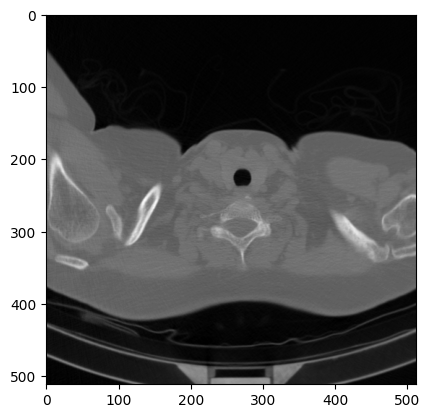

In [168]:
plt.imshow(f2,cmap='gray')

In [169]:
f2.min(), f2.max()

(-1024.0, 171.29187)

In [170]:
f2n = (f2 - f2.min()) / (f2.max() - f2.min()) 

In [171]:
f2n.min(), f2n.max()

(0.0, 1.0)

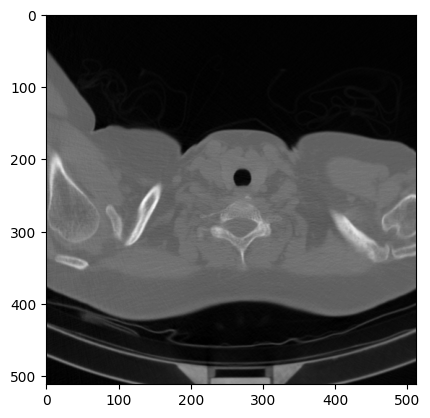

In [172]:
plt.imshow(f2n,cmap='gray')

In [174]:
f2 = f2[:, :, np.newaxis] # 512, 512, 1

In [175]:
f2.shape

(512, 512, 1)

# SERIES LEVEL

In [176]:
!git clone https://github.com/ShahinSHH/COVID-CT-MD.git

Cloning into 'COVID-CT-MD'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1117 (delta 15), reused 10 (delta 10), pack-reused 1101
Receiving objects: 100% (1117/1117), 214.00 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Updating files: 100% (914/914), done.


In [178]:
from tqdm.auto import tqdm
from pathlib import Path

In [179]:
slices = sorted(Path('/kaggle/working/COVID-CT-MD/Sample data/COVID-19 subjects/P002').glob('*'))

In [182]:
def open_sort(series_dir):
    slices = sorted(Path(series_dir).glob('*'))
    slices = [pydicom.read_file(s) for s in slices]
    slices = sorted(slices, key = lambda x: x.SliceLocation)
    return slices

In [183]:
p = '/kaggle/working/COVID-CT-MD/Sample data/COVID-19 subjects/P002'
series = open_sort(p)

In [187]:
series[0].SliceLocation, series[-1].SliceLocation

('-437.7', '-173.7')

In [195]:
def normalize(img, maxval):
    """Scales images to be roughly [-1024 1024]."""

    if img.max() > maxval:
        raise Exception("max image value ({}) higher than expected bound ({}).".format(img.max(), maxval))

    img = (2 * (img.astype(np.float32) / maxval) - 1.) * 1024

    return img

In [201]:
def process_slice(sl, fix_monochrome=True):
    
    if sl.PhotometricInterpretation not in ['MONOCHROME1', 'MONOCHROME2']:
        raise NotImplementedError(f'PhotometricInterpretation `{sl.PhotometricInterpretation}` is not yet supported.')
    
    max_possible_pixel_val = (2**sl.BitsStored - 1)
    data = sl.pixel_array

    if fix_monochrome and sl.PhotometricInterpretation == "MONOCHROME1":
        data = max_possible_pixel_val - data

    data = normalize(data, max_possible_pixel_val)
    
    # scale to [0,1]
    data = (data - data.min()) / (data.max() - data.min()) 
    
    return data

In [202]:
def process_series(series_path):
    series = open_sort(series_path)
    series = [process_slice(sl) for sl in series]
    series = np.stack(series,axis=-1)
    return series

In [203]:
se = process_series(p)

In [204]:
se.shape

(512, 512, 133)

## additionally we should add a channel dim at 0, for (C, H, W, D) for pytorch 3D models

In [206]:
from monai.visualize import matshow3d

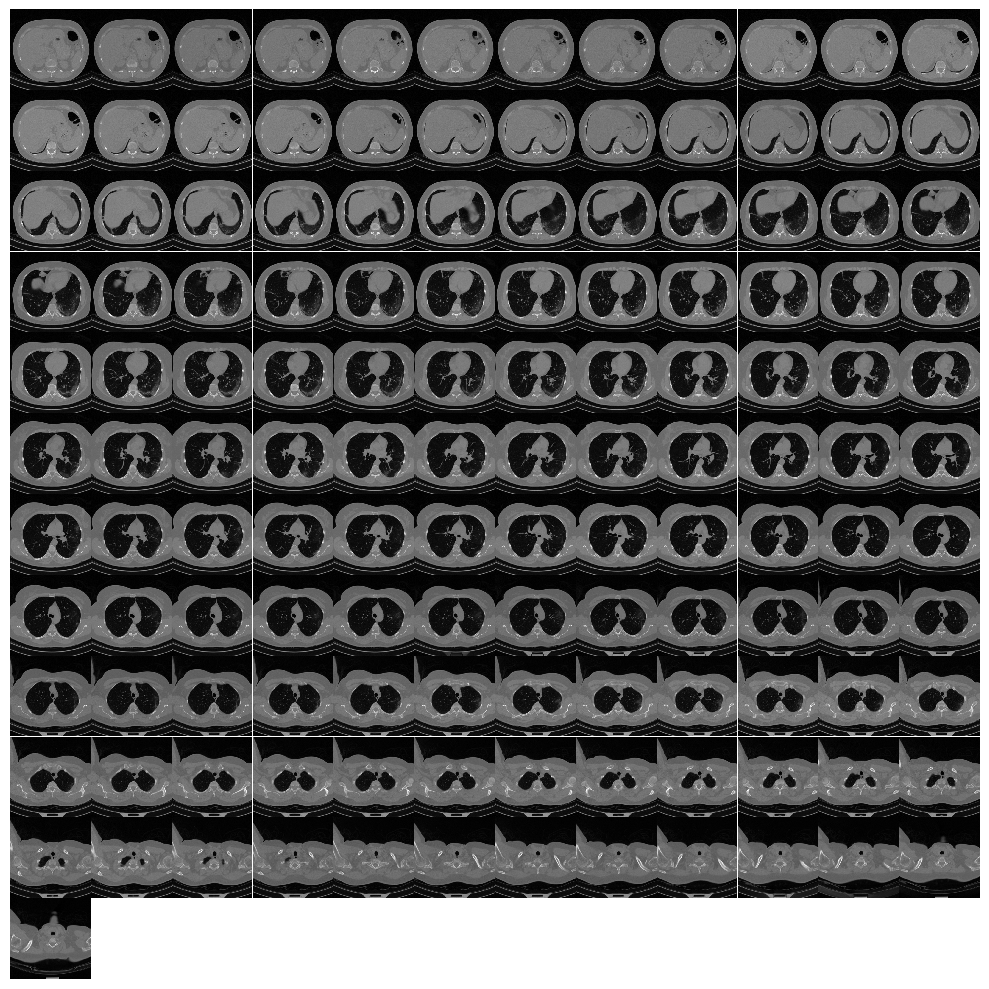

In [209]:
matshow3d(se,frame_dim=-1,cmap='gray')
plt.show()